# Nepali Sign Language Recognition - Transfer Learning

# 1. Import required libraries

In [1]:
# Ignore warnings
import logging, os, warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import numpy as np
import random

In [3]:
# Add path for helper_functions
import sys
sys.path.append("/home/aashish/Downloads/Nepali-Sign-Language-Recognition")
from helper_functions import show_images, plot_curves

In [4]:
# Set Devanagari font
plt.rcParams['font.family'] = 'Noto Sans Devanagari'

## 2. Data exploration

In [5]:
data_dir = pathlib.Path("/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['क' 'क्ष' 'ख' 'ग' 'घ' 'ङ' 'च' 'छ' 'ज' 'ज्ञ' 'झ' 'ञ' 'ट' 'ठ' 'ड' 'ढ' 'ण'
 'त' 'त्र' 'थ' 'द' 'ध' 'न' 'प' 'फ' 'ब' 'भ' 'म' 'य' 'र' 'ल' 'व' 'श' 'ष' 'स'
 'ह' '०' '१' '२' '३' '४' '५' '६' '७' '८' '९']


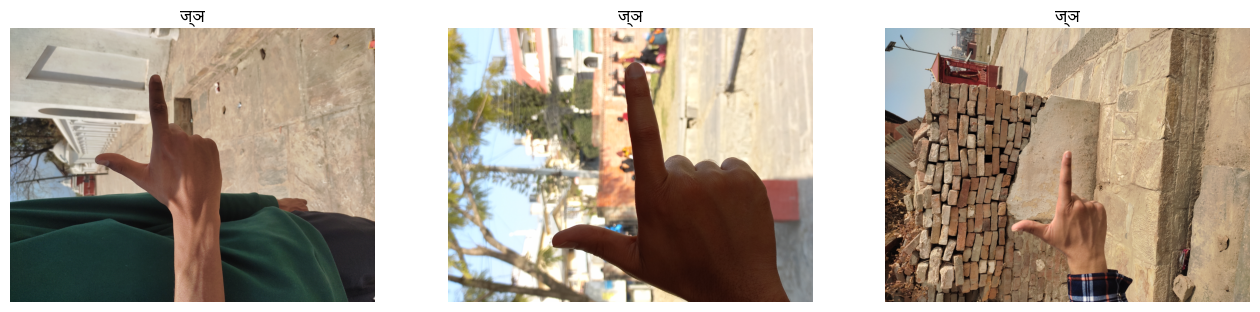

In [6]:
target_directory = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/train/"
class_name = "ज्ञ"
show_images(target_directory, class_name)

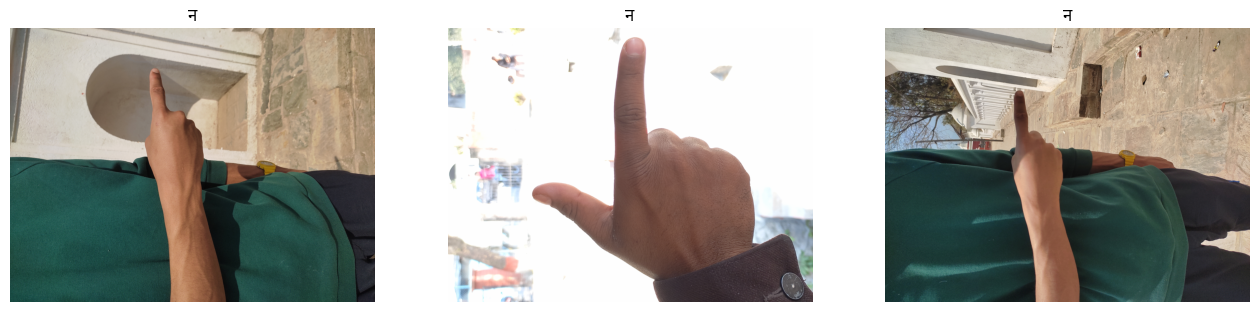

In [7]:
target_directory = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/train/"
class_name = "न"
show_images(target_directory, class_name)

## 3. Data Preprocessing

In [8]:
# Define path to train, test and validation set
train_dir = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/train/"
val_dir = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/validation/"
test_dir = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/test/"

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical", 
                                                                 image_size=IMG_SIZE)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir, 
                                                                label_mode="categorical", 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=False)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                label_mode="categorical", 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=False)

Found 1664 files belonging to 46 classes.
Found 357 files belonging to 46 classes.
Found 384 files belonging to 46 classes.


## 4. Model building (feature extraction) 

In [11]:
# Setup data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation_layer")

In [12]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name ="input_layer")
x = data_augmentation(inputs) # augment images
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
eff_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="eff_transfer_learning_model")

In [13]:
eff_model.summary()

Model: "eff_transfer_learning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_layer         │ (None, None, None, 3)  │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 46)             │        58,926 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,108,497 (15.67 MB)

 Trainable params: 58,926 (230.18 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

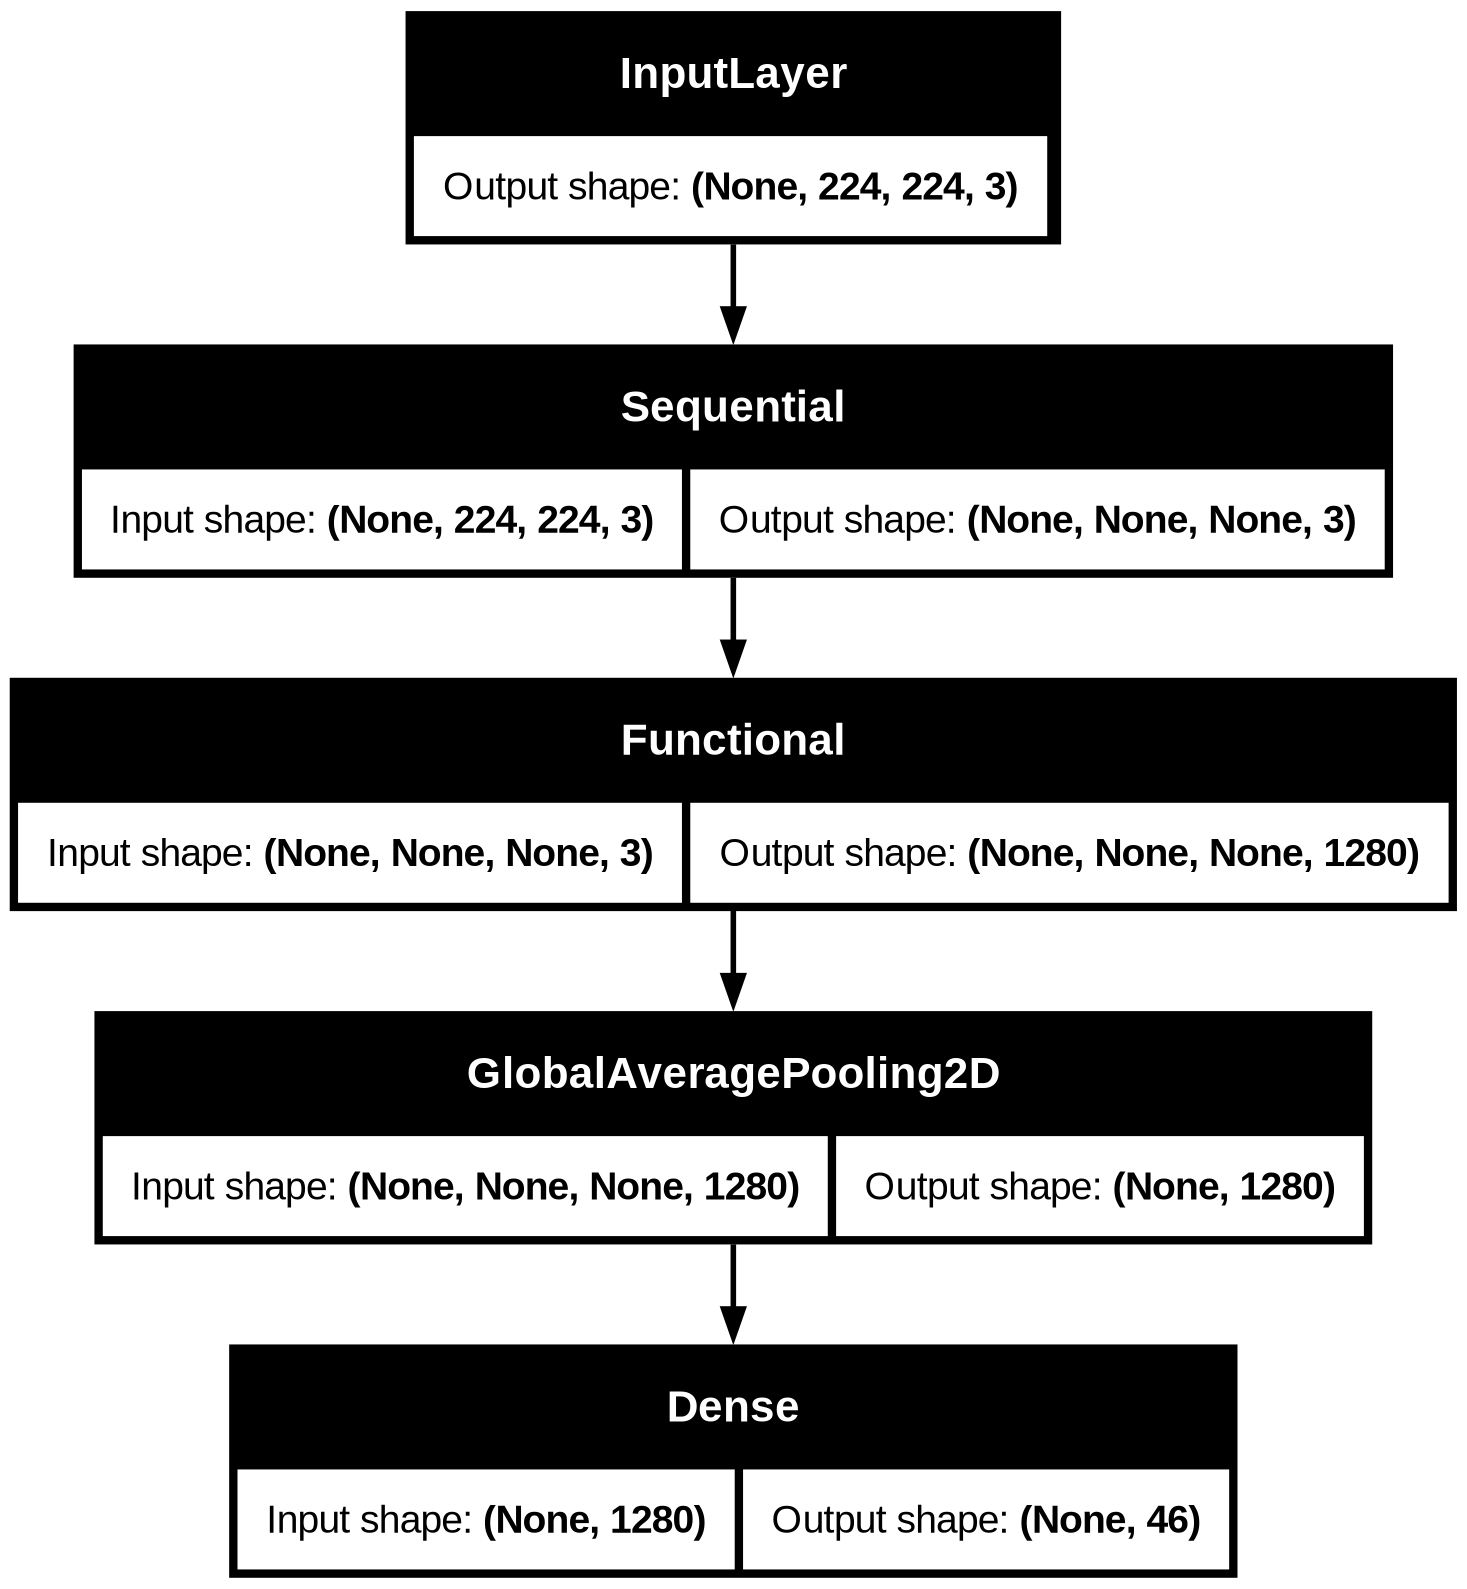

In [14]:
tf.keras.utils.plot_model(eff_model, "eff_transfer_learning_model.png", show_shapes=True)

In [15]:
# Compile the model
eff_model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(), 
              metrics=["accuracy"])

# Fit the model
eff_model_history_1 = eff_model.fit(train_data, 
                              epochs=25, 
                              validation_data=val_data
                             )

Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.0491 - loss: 3.8066 - val_accuracy: 0.1765 - val_loss: 3.2418
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.1948 - loss: 3.1276 - val_accuracy: 0.2801 - val_loss: 2.8472
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.3567 - loss: 2.7171 - val_accuracy: 0.3165 - val_loss: 2.6001
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.3954 - loss: 2.4549 - val_accuracy: 0.3501 - val_loss: 2.4124
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.5011 - loss: 2.1714 - val_accuracy: 0.3669 - val_loss: 2.2925
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.5444 - loss: 2.0029 - val_accuracy: 0.3641 - val_loss: 2.1840
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.5724 - loss: 1.8900 - val_accuracy: 0.4174 - val_loss: 2.0431
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.6165 - loss: 1.7559 - val_accuracy: 0

In [16]:
# Evaluate the model
eff_model_eval = eff_model.evaluate(test_data)
print(eff_model_eval)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.5661 - loss: 1.5203
[1.397347092628479, 0.6119791865348816]


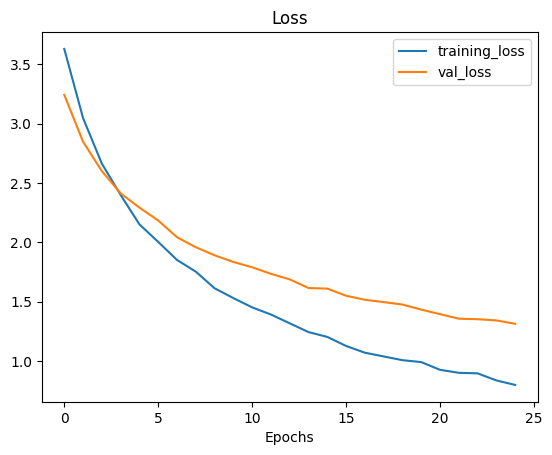

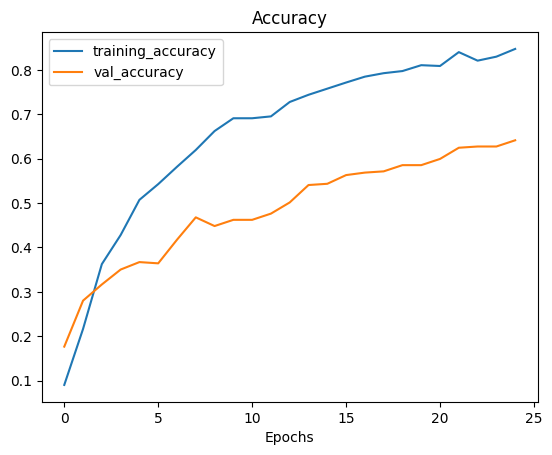

In [17]:
# Restore the default rc settings
plt.rcdefaults()

# Plot loss curves
plot_curves(eff_model_history_1)

## 5. Saving the `eff_model`

In [19]:
eff_model.save("eff_transfer_learning_model.keras")

## 6. Feature Extraction using MobilenetV3 

In [10]:
# Setup data augmentation
data_augmentation_1 = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomContrast(0.2),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation_layer")

In [14]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.MobileNetV3Large(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name ="input_layer")
x = data_augmentation_1(inputs) # augment images
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
mobv3_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mobv3_transfer_learning_model")

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [17]:
# Check the layers in base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer_3
1 rescaling_2
2 conv
3 conv_bn
4 activation_36
5 expanded_conv_depthwise
6 expanded_conv_depthwise_bn
7 re_lu_28
8 expanded_conv_project
9 expanded_conv_project_bn
10 expanded_conv_add
11 expanded_conv_1_expand
12 expanded_conv_1_expand_bn
13 re_lu_29
14 expanded_conv_1_depthwise_pad
15 expanded_conv_1_depthwise
16 expanded_conv_1_depthwise_bn
17 re_lu_30
18 expanded_conv_1_project
19 expanded_conv_1_project_bn
20 expanded_conv_2_expand
21 expanded_conv_2_expand_bn
22 re_lu_31
23 expanded_conv_2_depthwise
24 expanded_conv_2_depthwise_bn
25 re_lu_32
26 expanded_conv_2_project
27 expanded_conv_2_project_bn
28 expanded_conv_2_add
29 expanded_conv_3_expand
30 expanded_conv_3_expand_bn
31 re_lu_33
32 expanded_conv_3_depthwise_pad
33 expanded_conv_3_depthwise
34 expanded_conv_3_depthwise_bn
35 re_lu_34
36 expanded_conv_3_squeeze_excite_avg_pool
37 expanded_conv_3_squeeze_excite_conv
38 expanded_conv_3_squeeze_excite_relu
39 expanded_conv_3_squeeze_excite_conv_1
40 re_lu_35
41

In [18]:
base_model.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, None,      │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, None,      │        432 │ rescaling_2[0][0] │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, None,      │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, None,      │          0 │ conv_bn[0][0]     │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        144 │ activation_36[0]… │
│ (DepthwiseConv2D)   │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, None,      │          0 │ expanded_conv_de… │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        256 │ re_lu_28[0][0]    │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, None,      │          0 │ activation_36[0]… │
│ (Add)               │ None, 16)         │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, None,      │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, None,      │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, None,      │          0 │ expanded_conv_1_… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, None,      │          0 │ re_lu_29[0][0]    │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, None,      │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, None,      │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

In [15]:
mobv3_model.summary()

Model: "mobv3_transfer_learning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_layer         │ (None, None, None, 3)  │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, None, None,     │     2,996,352 │
│                                 │ 960)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 46)             │        44,206 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,040,558 (11.60 MB)

 Trainable params: 44,206 (172.68 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

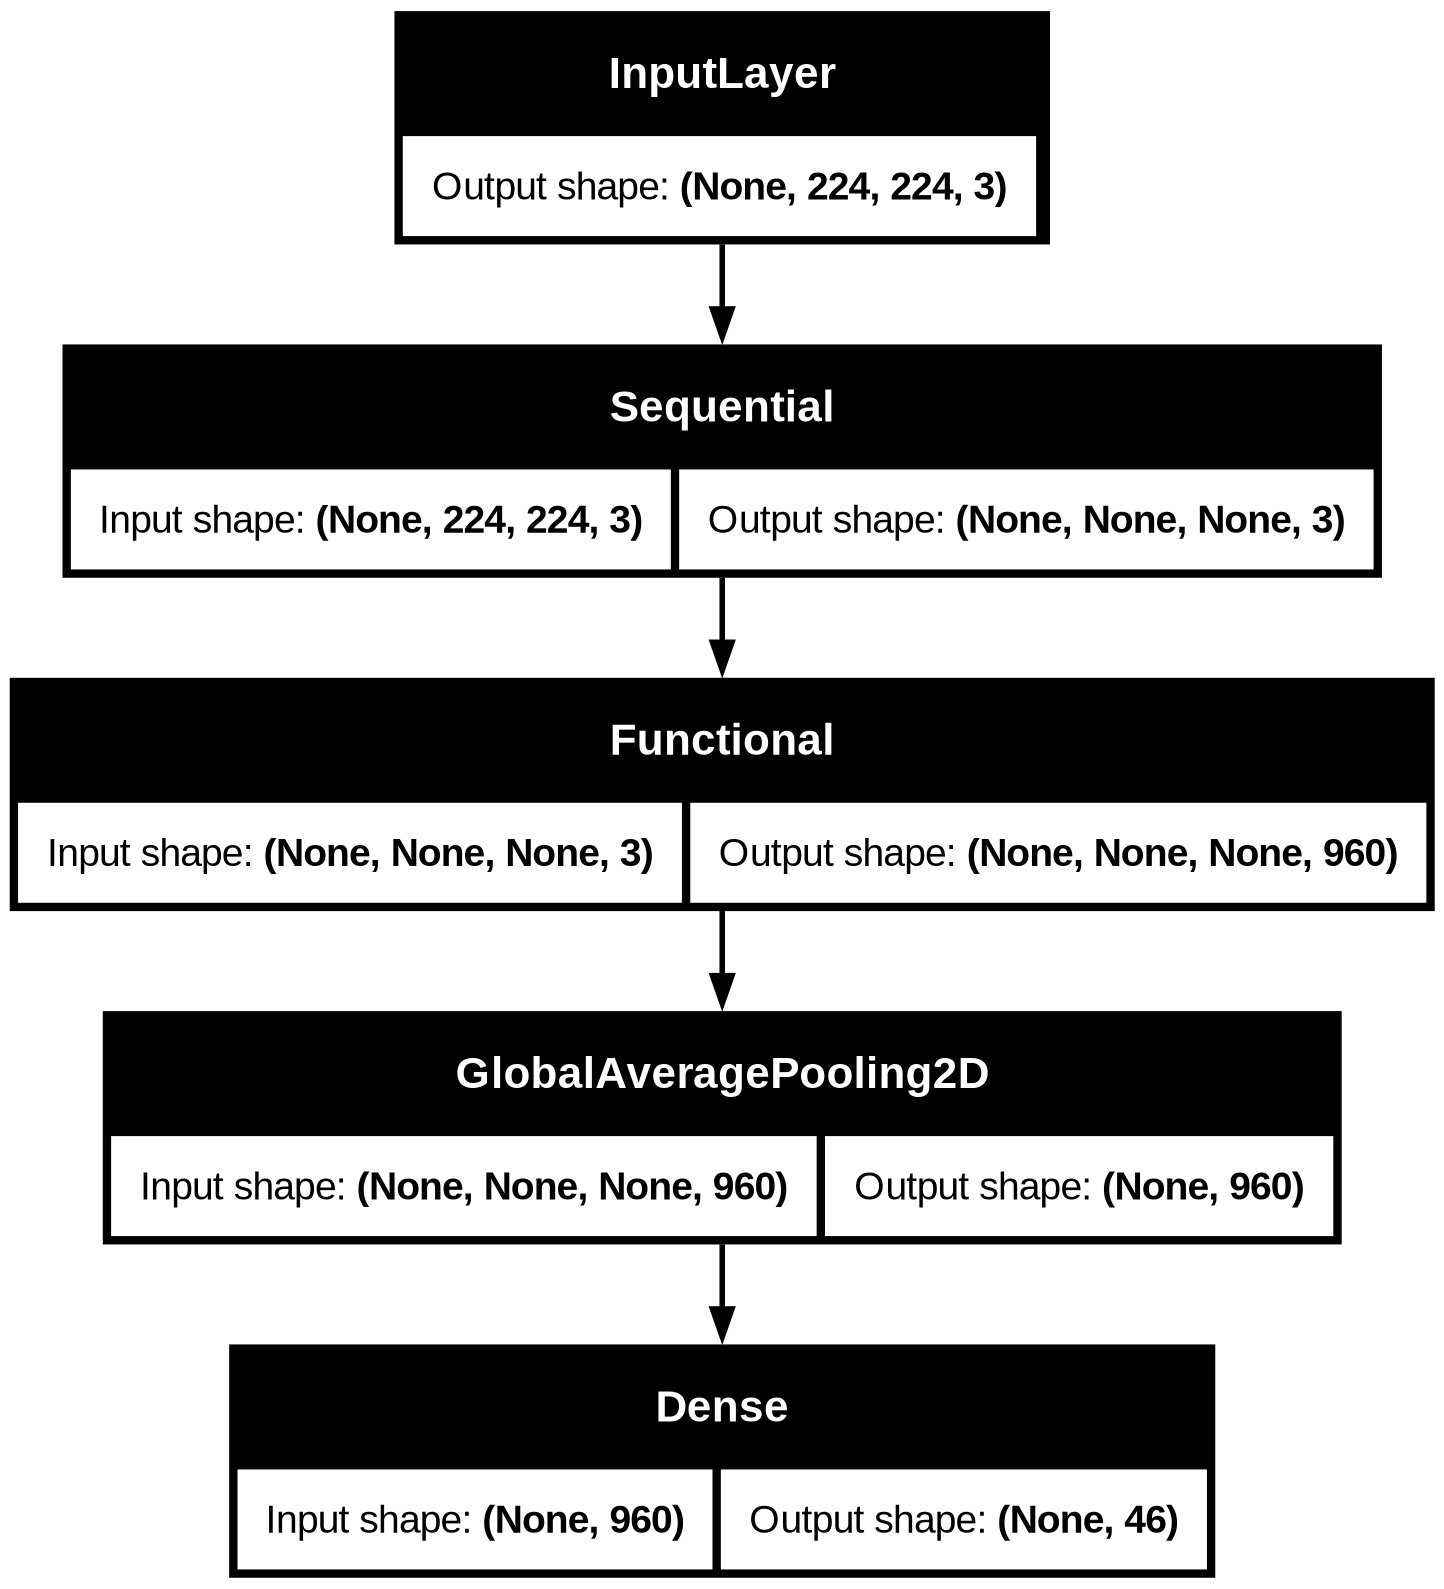

In [16]:
tf.keras.utils.plot_model(mobv3_model, "mobv3_transfer_learning_model.png", show_shapes=True)

In [20]:
# Compile the model
mobv3_model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(), 
              metrics=["accuracy"])

# Fit the model
mobv3_model_history = mobv3_model.fit(train_data, 
                              epochs=30,
                              validation_data=val_data
                             )

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.1621 - loss: 3.2115 - val_accuracy: 0.2437 - val_loss: 2.8601
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.3123 - loss: 2.5473 - val_accuracy: 0.2885 - val_loss: 2.5410
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.4103 - loss: 2.2531 - val_accuracy: 0.3501 - val_loss: 2.2475
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.5108 - loss: 1.9409 - val_accuracy: 0.4090 - val_loss: 2.0738
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.5853 - loss: 1.6979 - val_accuracy: 0.4482 - val_loss: 1.9579
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.6105 - loss: 1.5964 - val_accuracy: 0.4790 - val_loss: 1.8351
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.6567 - loss: 1.4486 - val_accuracy: 0.5014 - val_loss: 1.7474
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.6409 - loss: 1.3502 - val_accuracy: 

In [21]:
# Evaluate the model
mobv3_model_eval = mobv3_model.evaluate(test_data)
print(mobv3_model_eval)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.6489 - loss: 1.3450
[1.2173917293548584, 0.6848958134651184]


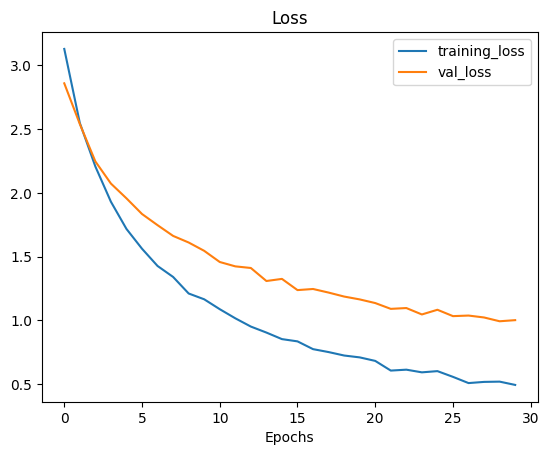

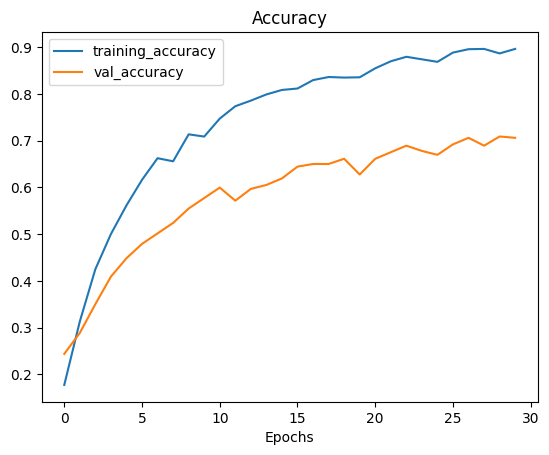

In [22]:
# Restore the default rc settings
plt.rcdefaults()

# Plot loss curves
plot_curves(mobv3_model_history)

## 7. Saving the `mobv3_model`

In [23]:
mobv3_model.save("mobv3_transfer_learning_model.keras")